In [ ]:
%tensorflow_version 2.x # selecting tensorflow version

!sudo pip install --upgrade pip;
!sudo pip install --upgrade tensorflow;

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---

## Στοιχεία Ομάδας

Αριθμός Ομάδας F05

  > Καρυπιάδης Ευστράτιος: 03114911
  
  > Σταματελόπουλος Νικόλαος: 03116138

---

## Σύνολο Δεδομένων CIFAR-100

Το σύνολο δεδομένων στο οποίο θα εργαστούμε είναι το [CIFAR-100](https://bit.ly/38CUquZ), το οποίο αποτελείται απο 60.000 έγχρωμες εικόνες διαστάσεων 32x32. Κάθε μία από αυτές ανήκει σε μία γενική(*fine*) και μία ειδική(*coarse*) κατηγορία του συνόλου, πλήθους 100 και 20 αντίστοιχα. Προς ταξινόμηση των δειγμάτων μας θα εκμεταλευτούμε μονάχα τις *fine* κατηγορίες των εικόνων που έχουμε στη διάθεσή μας.

	

### Εισαγωγή συνόλου δεδομένων

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models, utils
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

Για τους σκοπούς της άσκησης **δε** θα εκμεταλλευτούμε ολόκληρο το σύνολο δεδομένων, αλλά θα δουλέψουμε σε ένα υποσύνολο αυτού σύμφώνα με τον αύξοντα αριθμό της ομάδας μας, `team_seed`. Στη συνέχεια υλοποιούμε μία σειρά βοηθητικών συναρτήσεων που θα μας βοηθήσουν σε αυτόν το διαχωρισμό:

In [6]:
def select_from_list(from_list, index_list):
  """ Return from_list elemenents according to index contained in index_list. """
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

def get_ds_index(unfiliterd_list, target_list):
  """ Append in filtered_list the index of each element in unfiltered_list if it exists in target_list. """
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

def select_classes_number(classes_number=20):
  """ Select unique subset of CIFAR-100 with classes_number of classes. """
  if classes_number == 20:
    return "https://bit.ly/3b3Cewb"
  elif classes_number == 40:
    return "https://bit.ly/3aPo819"
  elif classes_number == 60:
    return "https://bit.ly/2Wbo47K"
  elif classes_number == 80:
    return "https://bit.ly/38NDW3d"
  else:
    return -1

### Διαχωρισμός δεδομένων εκπαίδευσης - ελέγχου

Στο επόμενο κελί επιλέγουμε το πλήθος των κατηγοριών με το οποίο επιθυμούμε να δουλέψουμε:

In [7]:
cifar100_classes_url = select_classes_number(classes_number=80) # default: 20 classes

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [8]:
team_seed = 5 # team_seed number

team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None) # fetch class indexes
CIFAR100_LABELS_LIST = pd.read_csv("https://bit.ly/3cRO3qZ", sep=',', header=None).astype(str).values.tolist()[0] # fetch class names

our_index = team_classes.iloc[team_seed, :].values.tolist() # select team class indices
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index) # select team class names

train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

# Train data and labels
x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))

# Test data and labels
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

Μετά την παραπάνω διαδικασία εμφανίζουμε τα ονόματα των κατηγοριών που αντιστοιχούν στην ομάδα μας:

In [9]:
print(our_classes)

[' aquarium_fish', ' baby', ' bear', ' beaver', ' bee', ' bicycle', ' bottle', ' bowl', ' boy', ' bus', ' camel', ' can', ' castle', ' caterpillar', ' cattle', ' chair', ' clock', ' cloud', ' cockroach', ' crab', ' crocodile', ' cup', ' dinosaur', ' dolphin', ' elephant', ' flatfish', ' forest', ' fox', ' girl', ' hamster', ' kangaroo', ' keyboard', ' lamp', ' lawn_mower', ' leopard', ' lion', ' lizard', ' lobster', ' man', ' maple_tree', ' motorcycle', ' mountain', ' mouse', ' mushroom', ' orange', ' orchid', ' otter', ' palm_tree', ' pickup_truck', ' pine_tree', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' road', ' rocket', ' rose', ' sea', ' seal', ' shark', ' skunk', ' skyscraper', ' snail', ' snake', ' squirrel', ' streetcar', ' sunflower', ' table', ' tank', ' television', ' tractor', ' train', ' trout', ' tulip', ' turtle', ' wardrobe', ' whale', ' wolf', ' worm']


### Επισκόπηση δεδομένων και κανονικοποίηση

Τέλος, για καλύτερη εποπτεία του συνόλου δεδομένων μας θα εξάγουμε ορισμένες χρήσιμες πληροφορίες για αυτό, ενώ παράλληλα θα κανονικοποιήσουμε τις τιμές αναπαράστασης των εικόνων:

In [10]:
data_size, img_rows, img_cols, img_channels = x_train_ds.shape # get train dataset dimensions

# Set validation set percentage
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# Summarize loaded dataset
print('Train:       X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation:  X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test:        X=%s, y=%s' % (x_test.shape, y_test.shape))

Train:       X=(34000, 32, 32, 3), y=(34000, 1)
Validation:  X=(6000, 32, 32, 3), y=(6000, 1)
Test:        X=(8000, 32, 32, 3), y=(8000, 1)


---

## Συναρτήσεις Προετοιμασίας Δεδομένων και Οπτικοποίησης Απόδοσης

Στη συνέχεια θα υλοποιήσουμε απαραίτητες συναρτήσεις προετοιμασίας των δεδομένων για εκπαίδευση, καθώς και οπτικοποίσης της τελικής απόδοσης των μοντέλων που πρόκειται να δοκιμάσουμε.

### Συναρτήσεις εκπαίδευσης

Αρχικά θα υλοποιήσουμε την `_input_fn`, η οποία αποτελεί ένα *pipeline* που θα προετοιμάσει τα δεδομένα μας για την εκπαίδευση. Πιο συγκεκριμένα, χρησιμοποιούμε τις μεθόδους `shuffle`, `repeat` και `batch` της [tf.data.Dataset](https://bit.ly/2vk7EPr), ώστε να δημιουργήσουμε υποσύνολα 64 δειγμάτων, τα οποία ελήφθησαν τυχαίως από το ολικό μας σύνολο. Παρατηρούμε ότι η μέθοδος `repeat` είναι απαραίτητη για να αντιμετωπίσουμε τυχόν σφάλμα που θα προκύψει, εάν η μέθοδος `batch` επιχειρήσει να δημιουργήσει εκ νέου υποσύνολο, αφού έχει ομαδοποιήσει όλα τα διαθέσιμα δείγματα του συνόλου. 

Σημειώνουμε ότι η συνάρτηση επιστρέφει υποσύνολα δεδομένων `PrefetchDataset Objects`, μορφή η οποία επιταχύνει τη διαδικασία εκπαίδευσης, καθώς επιτρέπει το διάβασμα του επόμενου batch δεδομένων, ενώ παράλληλα εκπαιδεύεται το παρόν.

In [11]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

def _input_fn(x, y, BATCH_SIZE):
  """ Returns shuffled and batched tensors in the form of PrefetchDataset objects. """
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# PrefetchDataset objects
train_ds =_input_fn(x_train, y_train, BATCH_SIZE)
validation_ds =_input_fn(x_val, y_val, BATCH_SIZE)
test_ds =_input_fn(x_test, y_test, BATCH_SIZE)

Στη συνέχεια υλοποιούμε τη συνάρτηση `train_model`. Σημειώνουμε ότι με την παράμετρο `steps_per_epoch` μπορούμε να επιλέξουμε το πλήθος των *batches* στο οποίο επιθυμούμε να εκπαιδευτεί το μοντέλο μας πριν περάσει στην επόμενη εποχή.

In [12]:
def train_model(model, epochs):
  """ Training function. """
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=x_train.shape[0]//BATCH_SIZE, validation_data=validation_ds, validation_steps=x_val.shape[0]//BATCH_SIZE)
  return(history)

### Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

Τέλος, υλοποιούμε συναρτήσεις οπτικοποίησης της απόδοσης της εκπαίδευσης προς εξαγωγή χρήσιμων πληροφοριών και μελέτη των αποτελεσμάτων που θα προκύψουν από τη δοκιμή των μοντέλων μας.

In [35]:
def summarize_diagnostics(history):
	""" Plot diagnostic learning curves. """
	plt.figure(figsize=(10, 6))
	plt.title('Classification Accuracy')
	if "history" in history:
		if "accuracy" in history.history:
			plt.plot(history.history['accuracy'], color='blue', label='Train')
			plt.plot(history.history['val_accuracy'], color='orange', label='Validation')
		else:
			plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='Train')
			plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='Validation')
	else:
		plt.plot(history['sparse_categorical_accuracy'], color='blue', label='Train')
		plt.plot(history['val_sparse_categorical_accuracy'], color='orange', label='Validation')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()
 
def model_evaluation(model, evaluation_steps):
	""" Print test set and evaluation metrics. """
	print('\nTest set evaluation metrics')
	loss0, accuracy0 = model.evaluate(test_ds, steps=x_test.shape[0]//BATCH_SIZE)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps=10):
	summarize_diagnostics(history)
	model_evaluation(model, evaluation_steps)
 
def summarize_all_diagnostics(m1, m2, m3, m4, m5):
	plt.figure(figsize=(10, 6))
	plt.title('Classification Accuracy')
	plt.plot(m1['accuracy'], color='red', linestyle='-', label='Softmax')
	plt.plot(m1['val_accuracy'], color='red', linestyle='--')
	plt.plot(m2['accuracy'], color='blue', linestyle='-', label='MLP')
	plt.plot(m2['val_accuracy'], color='blue', linestyle='--')
	plt.plot(m3['accuracy'], color='green', linestyle='-', label='LeNet')
	plt.plot(m3['val_accuracy'], color='green', linestyle='--')
	plt.plot(m4['accuracy'], color='orange', linestyle='-', label='CNN1')
	plt.plot(m4['val_accuracy'], color='orange', linestyle='--')
	plt.plot(m5['accuracy'], color='magenta', linestyle='-', label='CNN2')
	plt.plot(m5['val_accuracy'], color='magenta', linestyle='--')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()

---

## Ερώτημα 1: Μοντέλα Δικτύων

In [14]:
import json # for saving training history

Στη συνέχεια καλούμαστε να υλοποιήσουμε 5 διαφορετικές αρχιτεκτονικές συνελικτικών δικτύων. Για κάθε μία από αυτές θα πρέπει να επιλέξουμε δύο βέλτιστους συνδυασμούς optimizer, loss function, metrics και epoch.

- Σχετικά με τους [optimizers](https://keras.io/api/optimizers/) δοκιμάσαμε σε όλες τις αρχιτεκτονικές τους [Adam](https://keras.io/api/optimizers/adam/), [Nadam](https://keras.io/api/optimizers/Nadam/), [Adamax](https://keras.io/api/optimizers/adamax/), [Adagrad](https://keras.io/api/optimizers/adagrad/), [Adadelta](https://keras.io/api/optimizers/adadelta/), [RMSProp](https://keras.io/api/optimizers/rmsprop/) και [Stochastic Gradient Descent](https://keras.io/api/optimizers/sgd/). Επιλέξαμε δύο από αυτούς σε κάθε δίκτυο, ανάλογα με την απόδοσή τους. Αξίζει να σημειώσουμε ότι σε κάθε optimizer, πειραματιστήκαμε και με το ρυθμό μάθησης, για να αποφανθούμε για την επίδοσή του.

- Μελετώντας το API του Keras, παρατηρούμε ότι η μοναδική [loss function](https://keras.io/api/losses/) που εξυπηρετεί την επίλυση του προβλήματός μας είναι η [Categorical Cross Entropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Καταλήγουμε σε αυτήν την επιλογή, αγνοώντας αφενός τα regression losses, καθώς δεν εφάπτονται της ταξινόμησης εικόνων που επιχειρούμε και αφετέρου τις συναρτήσεις Kullback-Leibler Divergence και Hinge. Σχετικά με τις δύο τελευταίες, παρατηρούμε ότι μέσα από πειραματισμούς μας δε φαίνεται να συγκλίνουν σε ελάχιστη τιμή, ενώ παράλληλα δίνουν χαμηλές τιμές απόδοσης στα metrics που δοκιμάσαμε. Επίσης σημειώνουμε ότι οι συγκεκριμένες συναρτήσεις συνηθίζεται να χρησιμοποιούνται σε διαφορετικού τύπου εφαρμογές, όπως για παράδειγμα στους Autoencoders.

- Βασική μας [metric](https://keras.io/api/metrics/) συνάρτηση είναι η [ακρίβεια ταξινόμησης](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class), πάνω στην οποία θα στηριχτούμε προκειμένου να αποφανθούμε για την απόδοση των δικτύων μας.

- Τέλος, σημειώνουμε ότι κατά τη διαδικασία δοκιμών των παραπάνω παραμέτρων, εκπαιδεύσαμε πειραματικά κάθε δίκτυο για διάρκεια 10 εποχών. Σύμφωνα με τα αποτελέσματα που συλλέξαμε, επιλέξαμε για την εκάστοτε αρχιτεκτονική τους 2 καλύτερους συνδυασμούς, τους οποίους χρησιμοποιήσαμε για την ολοκληρωμένη εκπαίδευση, διάρκειας τουλάχιστον 50 εποχών, των τελικών 10 δικτύων μας.

### Softmax

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Παρατηρώντας το διάγραμμα απόδοσης που ακολουθεί, οι 50 `epochs` είναι αρκετές για την εκπαίδευση του μοντέλου, δεδομένου ότι δεν παρουσιάζεται τάση ανόδου για την απόδοση του δικτύου στα δεδομένα επαλήθευσης.

In [ ]:
def init_softmax_adam(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAM = init_softmax_adam(summary=True)

# Train for 50 epochs
SOFTMAX_MODEL_ADAM_history = train_model(SOFTMAX_MODEL_ADAM, 50)

# Dump training history
history_dict = SOFTMAX_MODEL_ADAM_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAM.json', 'w'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
531/531 [==============================] - 3s 5ms/step - loss: 4.1472 - accuracy: 0.0678 - val_loss: 3.9275 - val_accuracy: 0.1050
Epoch 2/50
531/531 [==============================] - 3s 5ms/step - loss: 3.8334 - accuracy: 0.1197 - val_loss: 3.7939 - val_accuracy: 0.1257
Epoch 3/50
531/531 [==============================] - 3s 5ms/step - loss: 3.7228 - accuracy: 0.1422 - val_loss: 3.7283 - val_accuracy: 0.1408
Epoch 4/50
531/531 [==============================] - 3s 5ms/step - loss: 3.6558 - a

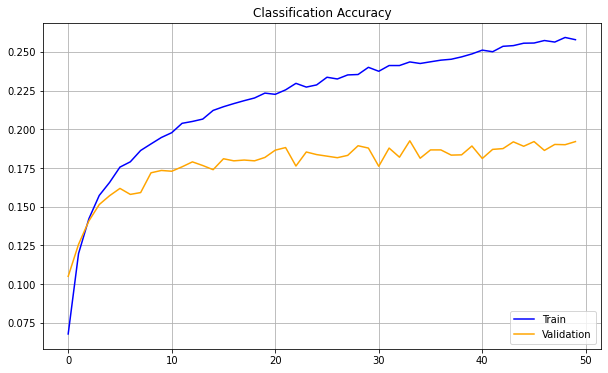


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.4880 - accuracy: 0.1950
loss: 3.49
accuracy: 0.19


In [ ]:
model_report(SOFTMAX_MODEL_ADAM, SOFTMAX_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε και εδώ τις 50 `epochs` εκπαίδευσης.

In [ ]:
def init_softmax_adagrad(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAGRAD = init_softmax_adagrad(summary=True)

# Train for 50 epochs
SOFTMAX_MODEL_ADAGRAD_history = train_model(SOFTMAX_MODEL_ADAGRAD, 50)

# Dump training history
history_dict = SOFTMAX_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
531/531 [==============================] - 3s 5ms/step - loss: 4.0586 - accuracy: 0.0795 - val_loss: 3.8279 - val_accuracy: 0.1243
Epoch 2/50
531/531 [==============================] - 3s 5ms/step - loss: 3.7369 - accuracy: 0.1322 - val_loss: 3.7234 - val_accuracy: 0.1435
Epoch 3/50
531/531 [==============================] - 3s 5ms/step - loss: 3.6335 - accuracy: 0.1565 - val_loss: 3.6664 - val_accuracy: 0.1546
Epoch 4/50
531/531 [==============================] - 3s 5ms/step - loss: 3.5699 - a

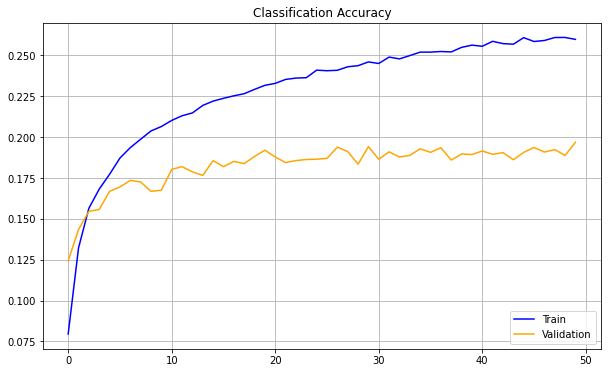


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.4727 - accuracy: 0.2014
loss: 3.47
accuracy: 0.20


In [ ]:
model_report(SOFTMAX_MODEL_ADAGRAD, SOFTMAX_MODEL_ADAGRAD_history)

### MLP

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Nadam` με `lr=0.0001`. Εδώ επιλέγουμε 75 `epochs` εκπαίδευσης παρατηρώντας την ανοδική τάσης της ακρίβειας του δικτύου στα δεδομένα επαλήθευσης που κυριαρχούσε στις 50 εποχές.

In [ ]:
def init_mlp_nadam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Nadam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_NADAM = init_mlp_nadam(summary=True)

# Train for 75 epochs
MLP_MODEL_NADAM_history = train_model(MLP_MODEL_NADAM, 75)

# Dump training history
history_dict = MLP_MODEL_NADAM_history.history
json.dump(history_dict, open('MLP_MODEL_NADAM.json', 'w'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_4 (Dense)              (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
531/531 [==============================] - 5s 9ms/step - loss: 4.0673 - accuracy: 0.0803 - val_loss: 3.8328 - val_accuracy: 0.1100
Epoch 2/75
531/531 [==============================] - 4s 8ms/step - loss: 3.6937 - accuracy: 0.1402 - val_loss: 3.6617 - val_accuracy: 0.1428
Epoch 3/75
531/531 [==============================] - 4s 8ms/step - loss: 3.5519 - accurac

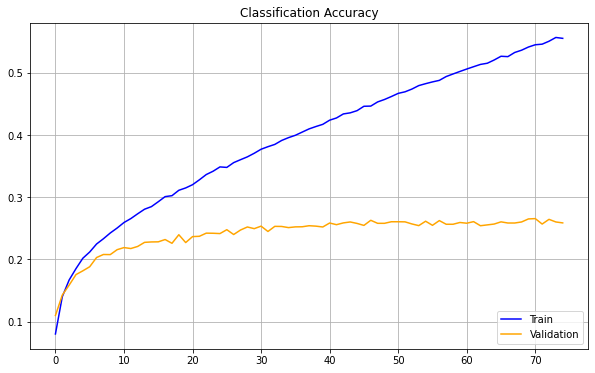


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.1842 - accuracy: 0.2707
loss: 3.18
accuracy: 0.27


In [ ]:
model_report(MLP_MODEL_NADAM, MLP_MODEL_NADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε τις 75 `epochs` εκπαίδευσης.

In [ ]:
def init_mlp_adagrad(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_ADAGRAD = init_mlp_adagrad(summary=True)

# Train for 100 epochs
MLP_MODEL_ADAGRAD_history = train_model(MLP_MODEL_ADAGRAD, 75)

# Dump training history
history_dict = MLP_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('MLP_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_6 (Dense)              (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
531/531 [==============================] - 3s 6ms/step - loss: 4.0713 - accuracy: 0.0732 - val_loss: 3.8278 - val_accuracy: 0.1131
Epoch 2/75
531/531 [==============================] - 3s 6ms/step - loss: 3.6952 - accuracy: 0.1321 - val_loss: 3.6423 - val_accuracy: 0.1512
Epoch 3/75
531/531 [==============================] - 3s 6ms/step - loss: 3.5548 - accurac

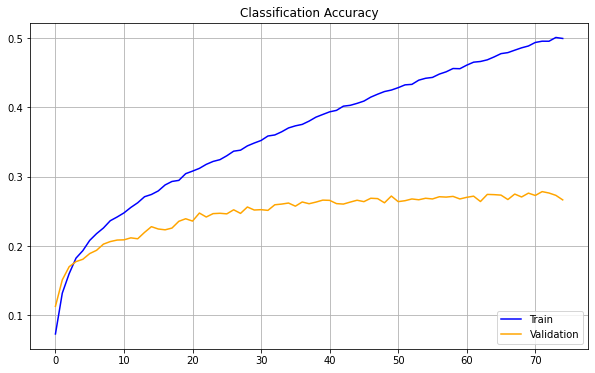


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 3.0427 - accuracy: 0.2810
loss: 3.04
accuracy: 0.28


In [ ]:
model_report(MLP_MODEL_ADAGRAD, MLP_MODEL_ADAGRAD_history)

### LeNet

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Ακολουθώντας το ίδιο σκεπτικό με παραπάνω, επιλέγουμε 100 `epochs` εκπαίδευσης.

In [ ]:
def init_lenet_adam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAM = init_lenet_adam(summary=True)

# Train for 100 epochs
LENET_MODEL_ADAM_history = train_model(LENET_MODEL_ADAM, 100)

# Dump training history
history_dict = LENET_MODEL_ADAM_history.history
json.dump(history_dict, open('LENET_MODEL_ADAM.json', 'w'))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 200)              

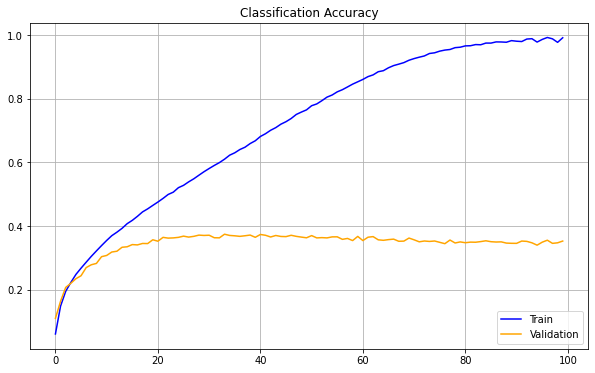


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 5.8648 - accuracy: 0.3591
loss: 5.86
accuracy: 0.36


In [ ]:
model_report(LENET_MODEL_ADAM, LENET_MODEL_ADAM_history)

Το δεύτερο μοντέλο έχει `Adamax` optimizer με `lr=0.01`. Διατηρούμε τις 100 `epochs` εκπαίδευσης.

In [ ]:
def init_lenet_adamax(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAMAX = init_lenet_adamax(summary=True)

# Train for 100 epochs
LENET_MODEL_ADAMAX_history = train_model(LENET_MODEL_ADAMAX, 100)

# Dump training history
history_dict = LENET_MODEL_ADAMAX_history.history
json.dump(history_dict, open('LENET_MODEL_ADAMAX.json', 'w'))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_10 (Dense)             (None, 200)              

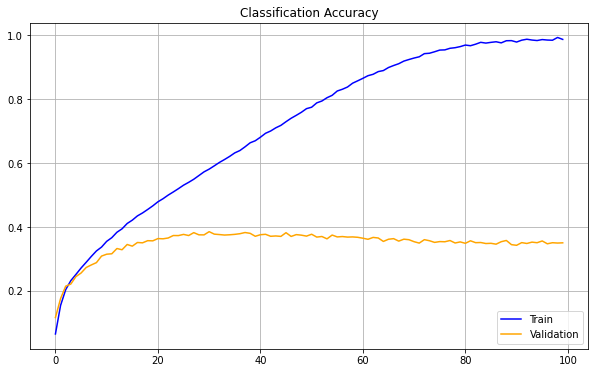


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 5.9529 - accuracy: 0.3595
loss: 5.95
accuracy: 0.36


In [ ]:
model_report(LENET_MODEL_ADAMAX, LENET_MODEL_ADAMAX_history)

### CNN1

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Ακολουθώντας το ίδιο σκεπτικό με παραπάνω, επιλέγουμε 100 `epochs` εκπαίδευσης.

In [ ]:
def init_cnn1_adam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_ADAM = init_cnn1_adam(summary=True)

# Train for 100 epochs
CNN1_MODEL_ADAM_history = train_model(CNN1_MODEL_ADAM, 100)

# Dump training history
history_dict = CNN1_MODEL_ADAM_history.history
json.dump(history_dict, open('CNN1_MODEL_ADAM.json', 'w'))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)              

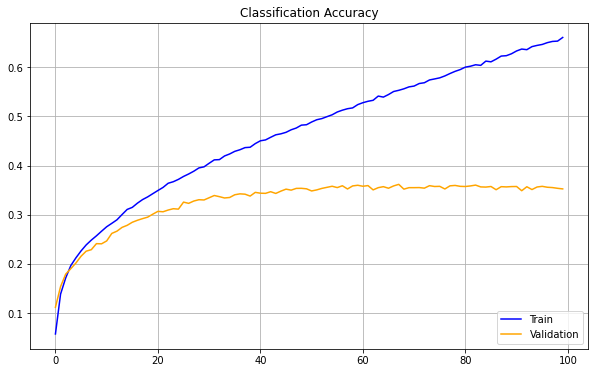


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 3.0260 - accuracy: 0.3626
loss: 3.03
accuracy: 0.36


In [ ]:
model_report(CNN1_MODEL_ADAM, CNN1_MODEL_ADAM_history)

Το δεύτερο μοντέλο έχει `SGD` optimizer με `lr=0.01`. Διατηρούμε τις 100 `epochs` εκπαίδευσης.

In [ ]:
def init_cnn1_sgd(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.SGD(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_SGD = init_cnn1_sgd(summary=True)

# Train for 100 epochs
CNN1_MODEL_SGD_history = train_model(CNN1_MODEL_SGD, 100)

# Dump training history
history_dict = CNN1_MODEL_SGD_history.history
json.dump(history_dict, open('CNN1_MODEL_SGD.json', 'w'))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 200)              

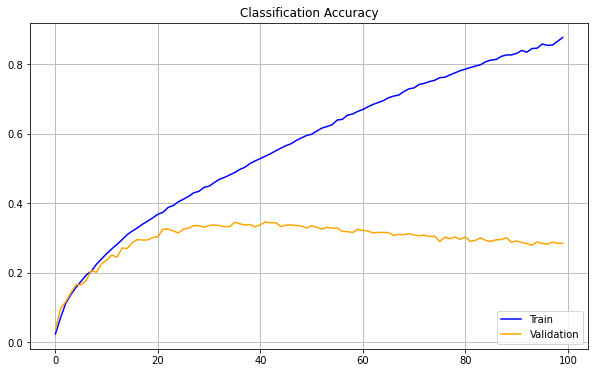


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 7.1988 - accuracy: 0.2973
loss: 7.20
accuracy: 0.30


In [ ]:
model_report(CNN1_MODEL_SGD, CNN1_MODEL_SGD_history)

### CNN2

Η αρχιτεκτονική του δικτύου μας είναι επηρεασμένη από εκείνη του VGG16. Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Παρατηρούμε ότι οι 50 `epochs` εκπαίδευσης είναι αρκετές για το μοντέλο μας.

In [ ]:
def init_CNN2_adam(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAM = init_CNN2_adam(summary=True)

# Train for 50 epochs
CNN2_MODEL_ADAM_history = train_model(CNN2_MODEL_ADAM, 50)

# Dump training history
history_dict = CNN2_MODEL_ADAM_history.history
json.dump(history_dict, open('CNN2_MODEL_ADAM.json', 'w'))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 512)        

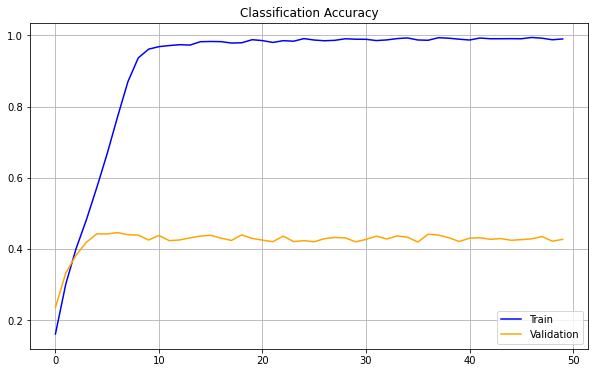


Test set evaluation metrics
125/125 [==============================] - 3s 23ms/step - loss: 5.6711 - accuracy: 0.4478
loss: 5.67
accuracy: 0.45


In [ ]:
model_report(CNN2_MODEL_ADAM, CNN2_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `RMSprop` optimizer με `lr=0.01`. Διατηρούμε σταθερή τη διάρκεια εκπαίδευσης στις 50 `epochs`.

In [ ]:
def init_CNN2_rmsprop(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.RMSprop(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_RMSPROP = init_CNN2_rmsprop(summary=True)

# Train for 50 epochs
CNN2_MODEL_RMSPROP_history = train_model(CNN2_MODEL_RMSPROP, 50)

# Dump training history
history_dict = CNN2_MODEL_RMSPROP_history.history
json.dump(history_dict, open('CNN2_MODEL_RMSPROP.json', 'w'))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 512)       

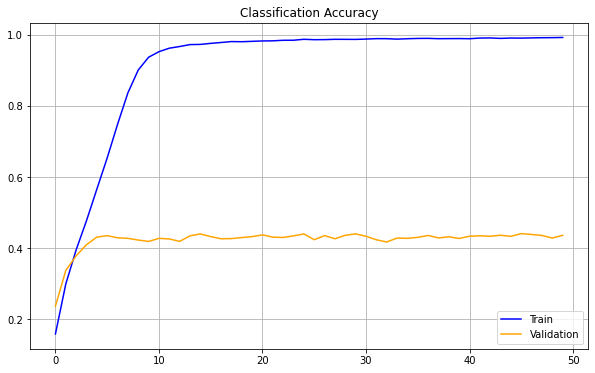


Test set evaluation metrics
125/125 [==============================] - 3s 23ms/step - loss: 7.9866 - accuracy: 0.4526
loss: 7.99
accuracy: 0.45


In [ ]:
model_report(CNN2_MODEL_RMSPROP, CNN2_MODEL_RMSPROP_history)

### Αξιολόγηση Μοντέλων

In [ ]:
# Reload best history according to accuracy-loss
m1 = json.load(open('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part1/SOFTMAX_MODEL_ADAGRAD.json', 'r'))
m2 = json.load(open('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part1/MLP_MODEL_ADAGRAD.json', 'r'))
m3 = json.load(open('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part1/LENET_MODEL_ADAM.json', 'r'))
m4 = json.load(open('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part1/CNN1_MODEL_ADAM.json', 'r'))
m5 = json.load(open('/content/drive/My Drive/ImageVideoAnalysis_ex2/trained_cnn/part1/CNN2_MODEL_ADAM.json', 'r'))

Παρακάτω παρουσιάζεται ένα συνολικό διάγραμμα των καλύτερων μοντέλων των παραπάνω αρχιτεκτονικών. Με συνεχόμενη γραμμή απεικονίζουμε την καμπύλη ακριβείας στα δεδομένα εκπαίδευσης, ενώ με διακεκομμένη την καμπύλη ακριβείας στα δεδομένα επαλήθευσης.

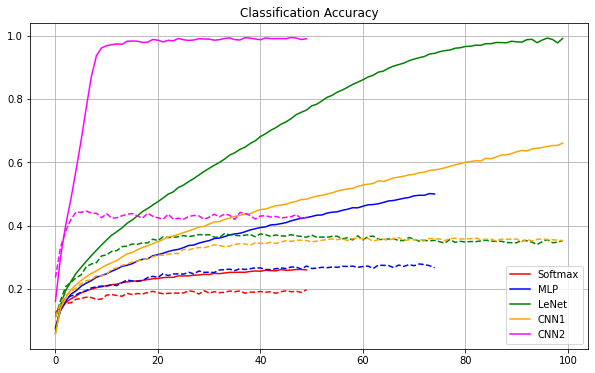

In [ ]:
summarize_all_diagnostics(m1, m2, m3, m4, m5)

---

## Ερώτημα 2: Αντιμετώπιση Υπερεκπαίδευσης

Μελετώντας τα διάγραμματα των παραπάνω αρχιτεκτονικών παρατηρούμε μία έντονη διαφορά μεταξύ των καμπυλών ακρίβειας στα δεδομένα εκπαίδευσης και επαλήθευσης. Αυτή η διαφορά υποδεικνύει το πρόβλημα του overfitting στα δεδομένα εκπαίδευσης, το οποίο θα επιχειρήσουμε να αντιμετωπίσουμε με τις παρακάτω τρεις τεχνικές:

- Θα εφαμόσουμε την τεχνική του `tf.keras.callbacks.EarlyStopping`, κατά την οποία η εκπαίδευση θα διακόπτεται έαν δεν υφίσταται βελτίωση στη μείωση του σφάλματος για περισσότερο από n κύκλους εκπαίδευσης. Επιλέγουμε `patience=10`.

- Θα προσθέσουμε στις αρχιτεκτονικές των δικτύων μας `tf.keras.layers.Dropout` layers.

- Τέλος, θα εκμεταλλευτούμε [ImageDataGenerator](https://bit.ly/33B1reJ), για να εφαρμόσουμε data augmentation στα δεδομένα εκπαίδευσης. Επιλέγουμε να χρησιμοποιήσουμε τους μετασχηματισμούς `rotation_range`, `width_shift_range`, `height_shift_range` και `horizontal_flip`.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialization of EarlyStopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

### Softmax

In [ ]:
def init_softmax_adagrad_opt(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAGRAD_OPT = init_softmax_adagrad_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
SOFTMAX_MODEL_ADAGRAD_OPT_history = SOFTMAX_MODEL_ADAGRAD_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
SOFTMAX_MODEL_ADAGRAD_OPT.save('SOFTMAX_MODEL_ADAGRAD_OPT.h5')

# Dump training history
history_dict = SOFTMAX_MODEL_ADAGRAD_OPT_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAGRAD_OPT.json', 'w'))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
531/531 [==============================] - 21s 40ms/step - loss: 4.1029 - sparse_categorical_accuracy: 0.0681 - val_loss: 3.8580 - val_sparse_categorical_accuracy: 0.1062
Epoch 2/200
531/531 [==============================] - 21s 40ms/step - loss: 3.8363 - sparse_categorical_accuracy: 0.1100 - val_loss: 3.7429 - val_sparse_categorical_accuracy: 0.1358
Epoch 3/200
531/531 [==============================] - 21s 40ms/step - loss: 3.7633 - sparse_categorical_accuracy: 0.1248 - val_loss: 3.7079 - 

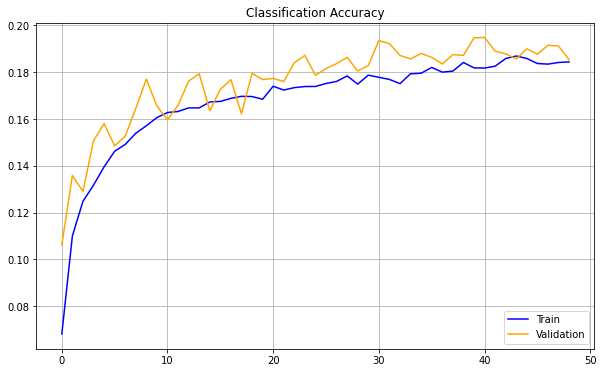


Test set evaluation metrics
125/125 [==============================] - 0s 3ms/step - loss: 3.4679 - sparse_categorical_accuracy: 0.1974
loss: 3.47
accuracy: 0.20


In [ ]:
model_report(SOFTMAX_MODEL_ADAGRAD_OPT, SOFTMAX_MODEL_ADAGRAD_OPT_history)

### MLP

In [ ]:
def init_mlp_adagrad_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_ADAGRAD_OPT = init_mlp_adagrad_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
MLP_MODEL_ADAGRAD_OPT_history = MLP_MODEL_ADAGRAD_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
MLP_MODEL_ADAGRAD_OPT.save('MLP_MODEL_ADAGRAD_OPT.h5')

# Dump training history
history_dict = MLP_MODEL_ADAGRAD_OPT_history.history
json.dump(history_dict, open('MLP_MODEL_ADAGRAD_OPT.json', 'w'))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
531/531 [==============================] - 23s 44ms/step - loss: 4.4141 - sparse_categorical_accuracy: 0.0422 - val_loss: 3.9827 - val_sparse_categorical_accuracy: 0.0813
Epoch 2/200
531/531 [==============================] - 22s

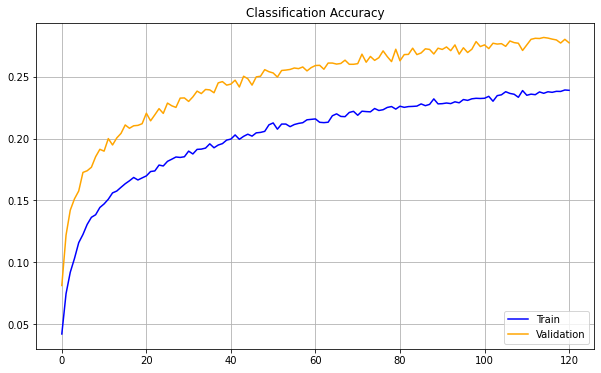


Test set evaluation metrics
125/125 [==============================] - 0s 4ms/step - loss: 2.9679 - sparse_categorical_accuracy: 0.2894
loss: 2.97
accuracy: 0.29


In [ ]:
model_report(MLP_MODEL_ADAGRAD_OPT, MLP_MODEL_ADAGRAD_OPT_history)

### LeNet

In [ ]:
def init_lenet_adam_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
LENET_MODEL_ADAM_OPT = init_lenet_adam_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
LENET_MODEL_ADAM_OPT_history = LENET_MODEL_ADAM_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
LENET_MODEL_ADAM_OPT.save('LENET_MODEL_ADAM_OPT.h5')

# Dump training history
history_dict = LENET_MODEL_ADAM_OPT_history.history
json.dump(history_dict, open('LENET_MODEL_ADAM_OPT.json', 'w'))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 2048)            

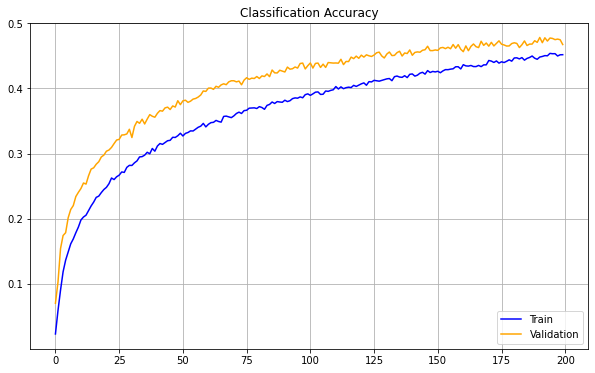


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 2.0119 - sparse_categorical_accuracy: 0.4757
loss: 2.01
accuracy: 0.48


In [ ]:
model_report(LENET_MODEL_ADAM_OPT, LENET_MODEL_ADAM_OPT_history)

### CNN1

In [ ]:
def init_cnn1_adam_opt(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Dropout(0.50))

  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN1_MODEL_ADAM_OPT = init_cnn1_adam_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=64, shuffle=True)

steps = int(x_train.shape[0]/64)
CNN1_MODEL_ADAM_OPT_history = CNN1_MODEL_ADAM_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
CNN1_MODEL_ADAM_OPT.save('CNN1_MODEL_ADAM_OPT.h5')

# Dump training history
history_dict = CNN1_MODEL_ADAM_OPT_history.history
json.dump(history_dict, open('CNN1_MODEL_ADAM_OPT.json', 'w'))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 16)        1216      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 32)        

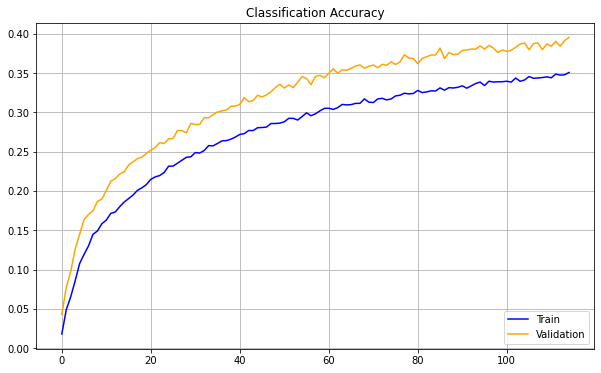


Test set evaluation metrics
125/125 [==============================] - 1s 5ms/step - loss: 2.3571 - sparse_categorical_accuracy: 0.4002
loss: 2.36
accuracy: 0.40


In [ ]:
model_report(CNN1_MODEL_ADAM_OPT, CNN1_MODEL_ADAM_OPT_history)

### CNN2

In [ ]:
def init_CNN2_adam_opt(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.10))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.50))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAM_OPT = init_CNN2_adam_opt(summary=True)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

steps = int(x_train.shape[0]/BATCH_SIZE)
CNN2_MODEL_ADAM_OPT_history = CNN2_MODEL_ADAM_OPT.fit(it_train, steps_per_epoch=steps, epochs=200, validation_data=(x_val, y_val), callbacks=[callback])

# Save model
CNN2_MODEL_ADAM_OPT.save('/content/drive/My Drive/ImageVideoAnalysis_ex2/repeat/CNN2_MODEL_ADAM_OPT.h5')

# Dump training history
history_dict = CNN2_MODEL_ADAM_OPT_history.history
json.dump(history_dict, open('/content/drive/My Drive/ImageVideoAnalysis_ex2/repeat/CNN2_MODEL_ADAM_OPT.json', 'w'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0

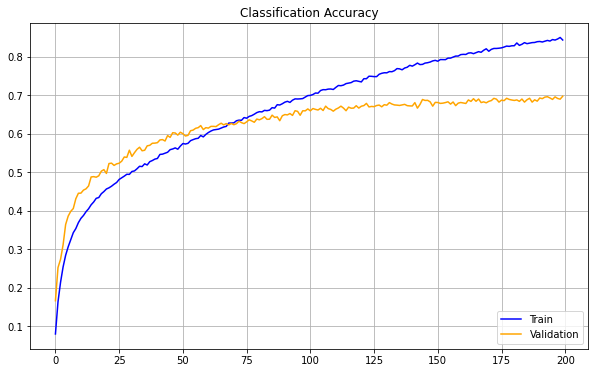


Test set evaluation metrics
125/125 [==============================] - 3s 22ms/step - loss: 1.2911 - sparse_categorical_accuracy: 0.7005
loss: 1.29
accuracy: 0.70


In [ ]:
model_report(CNN2_MODEL_ADAM_OPT, CNN2_MODEL_ADAM_OPT_history)

---

## Ερώτημα 3: Transfer Learning

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

RESNET_MODEL = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in RESNET_MODEL.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(layers.UpSampling2D())
model.add(layers.UpSampling2D())
model.add(layers.UpSampling2D())
model.add(RESNET_MODEL)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
datagen = ImageDataGenerator(rotation_range=0.10, width_shift_range=0.10, height_shift_range=0.10, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

steps = int(x_train.shape[0]/BATCH_SIZE)
RESNET_MODEL_history = model.fit(it_train, steps_per_epoch=steps, epochs=10, validation_data=(x_val, y_val), callbacks=[callback])

Epoch 1/10
531/531 [==============================] - 691s 1s/step - loss: 2.2828 - sparse_categorical_accuracy: 0.4305 - val_loss: 6.2775 - val_sparse_categorical_accuracy: 0.0303
Epoch 2/10
531/531 [==============================] - 690s 1s/step - loss: 1.2997 - sparse_categorical_accuracy: 0.6340 - val_loss: 1.4287 - val_sparse_categorical_accuracy: 0.5940
Epoch 3/10
531/531 [==============================] - 690s 1s/step - loss: 1.0632 - sparse_categorical_accuracy: 0.6923 - val_loss: 0.9637 - val_sparse_categorical_accuracy: 0.7182
Epoch 4/10
531/531 [==============================] - 690s 1s/step - loss: 0.9235 - sparse_categorical_accuracy: 0.7280 - val_loss: 0.9070 - val_sparse_categorical_accuracy: 0.7303
Epoch 5/10
531/531 [==============================] - 689s 1s/step - loss: 0.8330 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.8517 - val_sparse_categorical_accuracy: 0.7523
Epoch 6/10
531/531 [==============================] - 689s 1s/step - loss: 0.7709 - sparse_cate

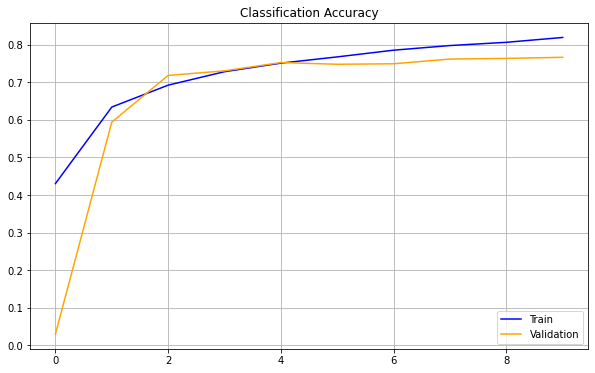


Test set evaluation metrics
125/125 [==============================] - 16s 132ms/step - loss: 0.7774 - sparse_categorical_accuracy: 0.7814
loss: 0.78
accuracy: 0.78


In [37]:
# Save model
# model.save('RESNET_MODEL.h5')
model = keras.models.load_model('drive/My Drive/RESNET_MODEL.h5')

# Dump training history
# history_dict = RESNET_MODEL_history.history
# json.dump(history_dict, open('RESNET_MODEL.json', 'w'))
RESNET_MODEL_history = json.load(open('RESNET_MODEL.json', 'r'))

model_report(model, RESNET_MODEL_history)